# Performing classification on Haxby dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn import image
from nilearn.plotting import plot_stat_map, show
%matplotlib inline

We use the Haxby dataset, that yields for each subject a big 4D image of n=1432 scans associated with the present of 8 different stimulus categories (classes of images that were presented to the participant) or rest.
See: https://nilearn.github.io/stable/auto_examples/02_decoding/plot_haxby_stimuli.html
Besides, this volume of data can be split into 9 independent sessions.
The name of the game is to perform classification on these data.

In [2]:
haxby_dataset = datasets.fetch_haxby()
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions != 'rest'
conditions = conditions[condition_mask]
print(conditions.unique())
session = labels['chunks'][condition_mask]


Dataset created in C:\Users\matte/nilearn_data\haxby2001



 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 284327936 of 291168628 bytes (97.7%,    0.5s remaining) ...done. (20 seconds, 0 min)
Extracting data from C:\Users\matte/nilearn_data\haxby2001\0a7df7e6986f9ca94043f4c67ae3792a\subj2-2010.01.14.tar.gz...

Mask nifti image (3D) is located at: C:\Users\matte/nilearn_data\haxby2001\mask.nii.gz
Functional nifti image (4D) is located at: C:\Users\matte/nilearn_data\haxby2001\subj2\bold.nii.gz
['scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle' 'chair']


.. done.


In [3]:
labels[:40]

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
5,rest,0
6,scissors,0
7,scissors,0
8,scissors,0
9,scissors,0


### Masking the data

This basically amounts to converting brain images to arrays for use in scikit learn or equivalent libraries.
Side information (labels and sessions) is also taken care of.

In [4]:
mask_filename = haxby_dataset.mask
masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4,
            standardize=True, memory="nilearn_cache", memory_level=1)
func_filename = haxby_dataset.func[0]
X = masker.fit_transform(func_filename)
X = X[condition_mask]
y = conditions.values
n_conditions = len(np.unique(y))

c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\nilearn\image\resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Then we can create a classifier to work on the data. A relevant one for functional imaging concatenates univariate features eelction with a multivariate classifier, e.g. an SVM. 

In [5]:
clf = SVC(kernel='linear', C=1.)
feature_selection = SelectKBest(f_classif, k=500)
anova_svc = Pipeline([('anova', feature_selection), ('svc', clf)])
cv = LeaveOneGroupOut()
cv_scores = cross_val_score(anova_svc, X, y, cv=cv.split(X, y, session), n_jobs=4, verbose=1)
print("Classification accuracy: %f / Chance level: %f "
      % (np.mean(cv_scores), 1. / n_conditions))


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    8.1s finished


Classification accuracy: 0.590278 / Chance level: 0.125000 


We do much better than chance in terms of accuracy. We can also plot the confusion matrix of the classifier.

In [6]:
condition_ids = np.unique(conditions)
confusion = np.zeros((n_conditions, n_conditions))
for train, test in cv.split(X, y, session):
    y_pred = anova_svc.fit(X[train], y[train]).predict(X[test])
    for j, k in zip(y[test], y_pred):
        confusion[condition_ids == j, condition_ids == k] += 1

confusion /= confusion.sum(0)

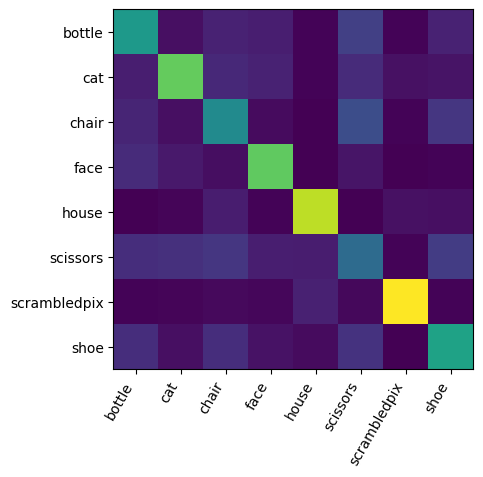

In [7]:
plt.figure()
ax = plt.subplot(111)
ax.imshow(confusion, interpolation='nearest')
plt.xticks(np.arange(n_conditions), condition_ids)
ax.set_xticklabels(condition_ids, rotation=60, ha='right')
plt.yticks(np.arange(n_conditions), condition_ids)
ax.set_position([.05, .15, .9, .75])
plt.show()

Eventually, we can look at the model weights. Those are obtained from the estimatir and "inverse transformed" to a brain image.

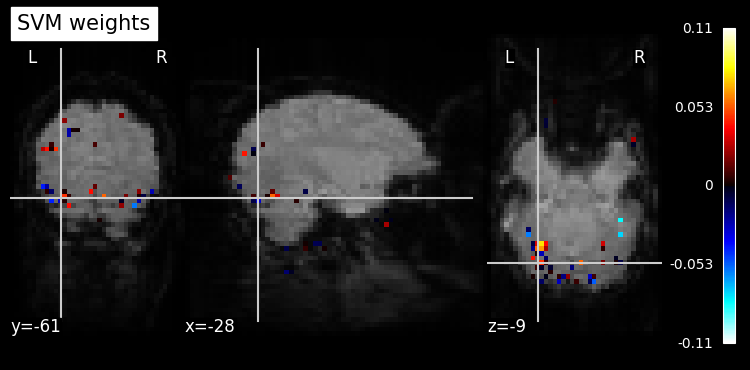

In [8]:
coef = feature_selection.inverse_transform(anova_svc.named_steps['svc'].coef_[:1])
weight_img = masker.inverse_transform(coef[0])
mean_img = image.mean_img(func_filename)
plot_stat_map(weight_img, mean_img, title='SVM weights')
weight_img.to_filename('haxby_face_vs_house.nii.gz')